In [137]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [138]:
train = pd.read_csv('data/train.csv', sep=';', delimiter=',', 
                    dtype={'fullVisitorId' : str, 'visitId' : str}).sample(frac=0.1).reset_index(drop=True)

In [139]:
train.info()
train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90365 entries, 0 to 90364
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   channelGrouping       90365 non-null  object
 1   date                  90365 non-null  int64 
 2   device                90365 non-null  object
 3   fullVisitorId         90365 non-null  object
 4   geoNetwork            90365 non-null  object
 5   sessionId             90365 non-null  object
 6   socialEngagementType  90365 non-null  object
 7   totals                90365 non-null  object
 8   trafficSource         90365 non-null  object
 9   visitId               90365 non-null  object
 10  visitNumber           90365 non-null  int64 
 11  visitStartTime        90365 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 8.3+ MB


,date,visitNumber,visitStartTime
count,9.036500e+04,90365.000000,9.036500e+04
mean,2.016588e+07,2.274597,1.485005e+09
std,4.697868e+03,9.154635,9.023976e+06
min,2.016080e+07,1.000000,1.470035e+09
25%,2.016103e+07,1.000000,1.477567e+09
50%,2.017011e+07,1.000000,1.483935e+09
75%,2.017042e+07,1.000000,1.492765e+09
max,2.017080e+07,383.000000,1.501657e+09


In [140]:
train.head()

,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Social,20161231,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",3262951815402105817,"{""continent"": ""Asia"", ""subContinent"": ""Souther...",3262951815402105817_1483233327,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""referralPath"": ""/yt/about/et/index.html"", ""c...",1483233327,1,1483233327
1,Referral,20170426,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3052922343428819105,"{""continent"": ""Americas"", ""subContinent"": ""Nor...",3052922343428819105_1493266138,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""15"", ""pageviews"": ""10""}","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1493266138,2,1493266138
2,Organic Search,20170702,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",1619985793777082863,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",1619985793777082863_1499030985,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""7"", ""pageviews"": ""6"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1499030985,1,1499030985
3,Direct,20161010,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1437337405701948134,"{""continent"": ""Asia"", ""subContinent"": ""Souther...",1437337405701948134_1476105828,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1476105828,1,1476105828
4,Social,20161109,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",5318540859809257091,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",5318540859809257091_1478685398,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""2"", ""pageviews"": ""2"",...","{""referralPath"": ""/yt/about/vi/"", ""campaign"": ...",1478685398,1,1478685398


In [141]:
train.date = pd.to_datetime(train.date, format='%Y%m%d')
train.visitStartTime = pd.to_datetime(train.visitStartTime, unit='s')
train = pd.merge(left=train, right=pd.json_normalize(train.device.apply(json.loads)), 
                 left_index=True, right_index=True).drop('device', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.geoNetwork.apply(json.loads)), 
                 left_index=True, right_index=True).drop('geoNetwork', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.totals.apply(json.loads)), 
                 left_index=True, right_index=True).drop('totals', axis=1)
train = pd.merge(left=train, right=pd.json_normalize(train.trafficSource.apply(json.loads)), 
                 left_index=True, right_index=True).drop('trafficSource', axis=1)

In [142]:
train.isTrueDirect = train.isTrueDirect.fillna(False)
train.hits = train.hits.astype(int)
train.visits = train.visits.astype(int)
train.pageviews = train.pageviews.fillna(train.pageviews.astype(float).mean())
train.pageviews = train.pageviews.astype(int)
train.newVisits = train.newVisits.fillna(0)
train.newVisits = train.newVisits.astype(int)
train.bounces = train.bounces.fillna(0).astype(int)
train.transactionRevenue = train.transactionRevenue.fillna(0).astype(float)

In [158]:
for c in train:
    if train[c].nunique() <= 50:
        print(c, train[c].nunique())

channelGrouping 3
browser 32
operatingSystem 4
isMobile 2
deviceCategory 3
continent 3
subContinent 23
bounces 2
newVisits 2
campaign 8
medium 2
isTrueDirect 2
adContent 30
adwordsClickInfo.page 5
adwordsClickInfo.slot 2
adwordsClickInfo.adNetworkType 2


In [144]:
for c in train:
    if train[c][0] == 'not available in demo dataset' or train[c].nunique() == 1:
        train = train.drop(c, axis=1)

In [145]:
for c in train:
    if 2 < train[c].nunique() < 5:
        train[c] = train[c].astype('category').cat.codes

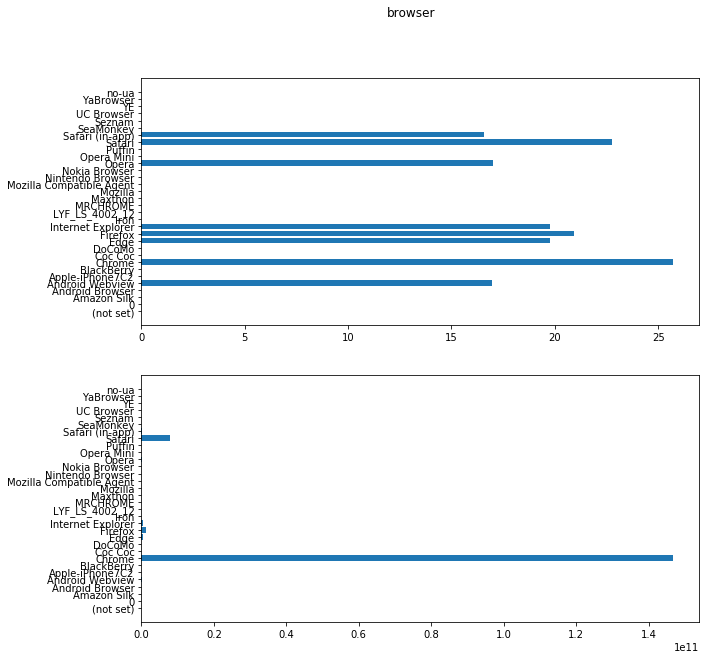

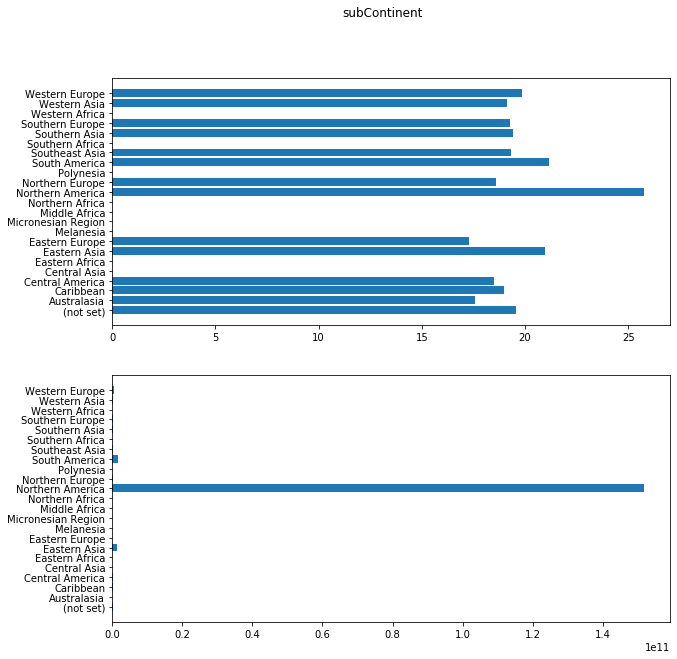

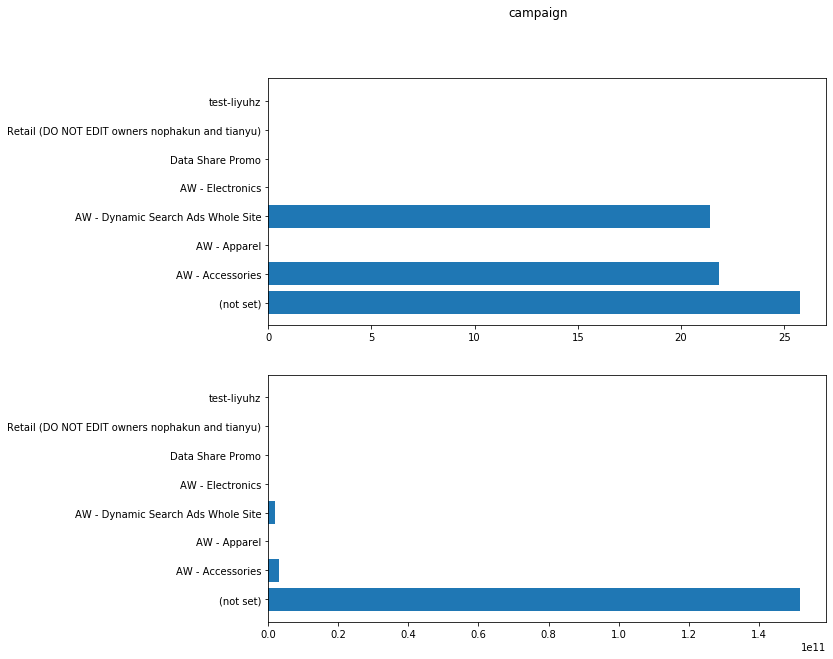

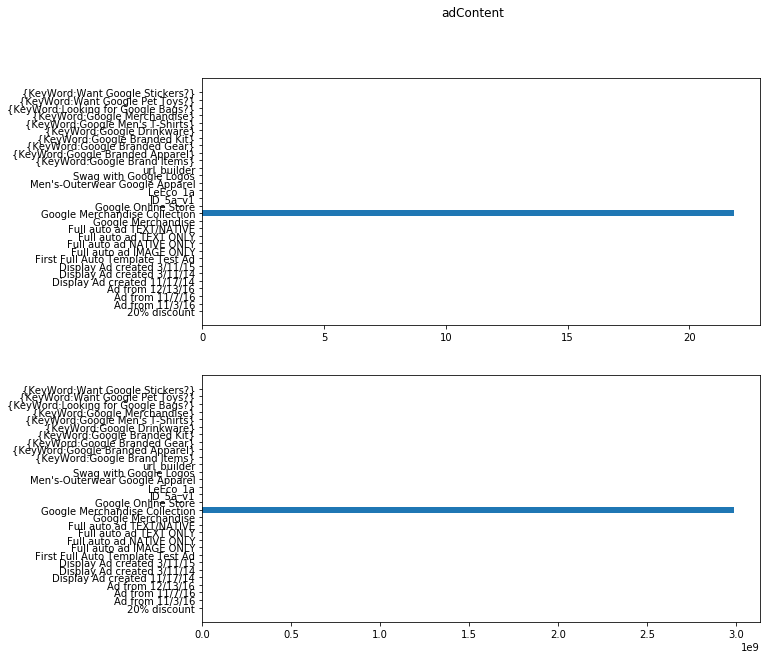

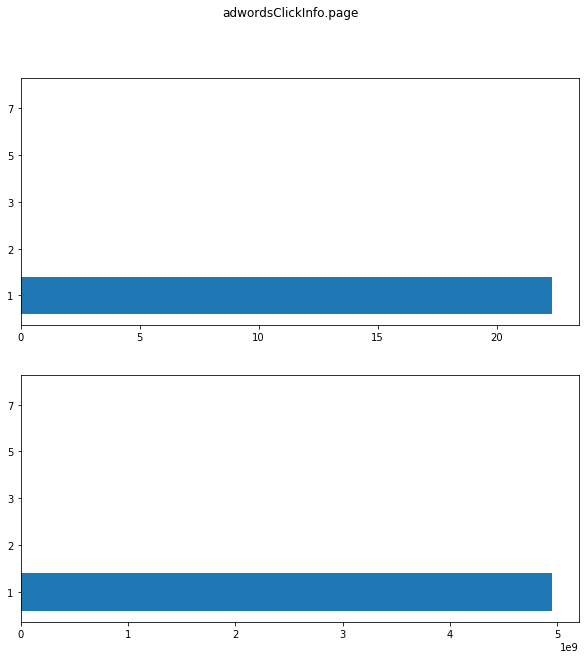

In [165]:
for c in train:
    if 5 <= train[c].nunique() <= 50:
        fig, axs = plt.subplots(2, figsize=(10, 10))
        fig.suptitle(c)
        grouped = train.groupby(c).transactionRevenue.sum().reset_index()
        axs[0].barh(grouped[c], np.log(1 + grouped.transactionRevenue))
        axs[1].barh(grouped[c], grouped.transactionRevenue)
        plt.show()

In [147]:
def get_codes_by_conditions(column, df, conditions):
    df = df.groupby(column).transactionRevenue.sum().reset_index()
    codes = {}
    value = np.log(1 + df.transactionRevenue)
    for c in range(len(conditions) - 1):
        values = df.loc[(conditions[c] <= value) & (value < conditions[c + 1])][column]
        for v in values:
            codes[v] = c
    return codes

In [148]:
def show_subplots(column, df):
    fig, axs = plt.subplots(2, figsize=(10, 10))
    fig.suptitle(column)
    grouped = df.groupby(column).transactionRevenue.sum().reset_index()
    axs[0].barh(grouped[column], np.log(1 + grouped.transactionRevenue))
    axs[1].barh(grouped[column], grouped.transactionRevenue)
    plt.show()

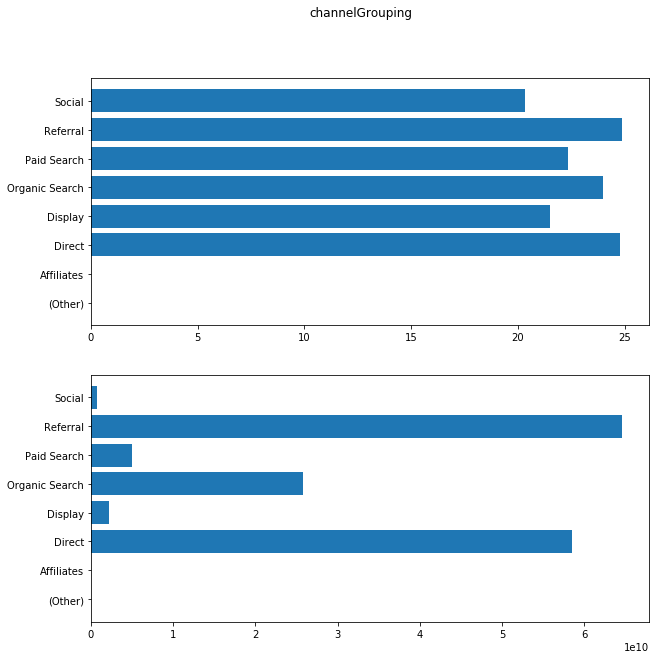

In [149]:
show_subplots('channelGrouping', train)

In [150]:
conditions = [0, 15, 23, 30]
train.channelGrouping = train.channelGrouping.map(get_codes_by_conditions('channelGrouping', train, conditions))

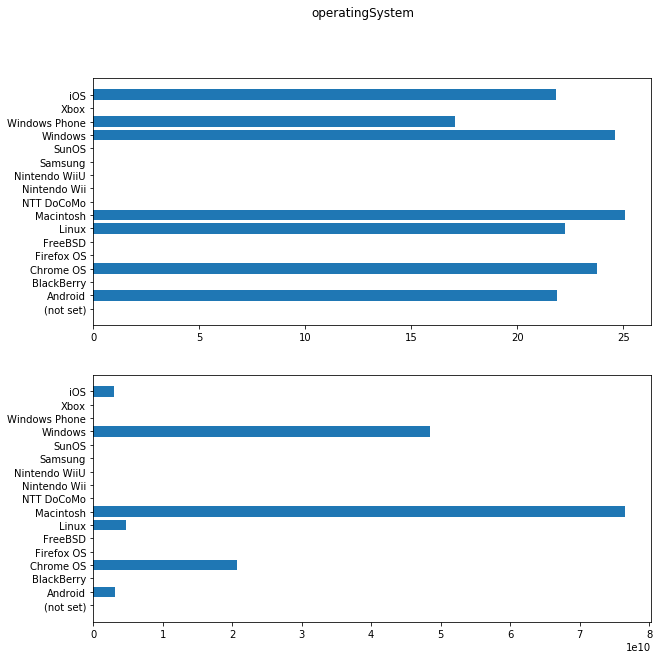

In [151]:
show_subplots('operatingSystem', train)

In [152]:
conditions = [0, 15, 20, 24, 30]
train.operatingSystem = train.operatingSystem.map(get_codes_by_conditions('operatingSystem', train, conditions))

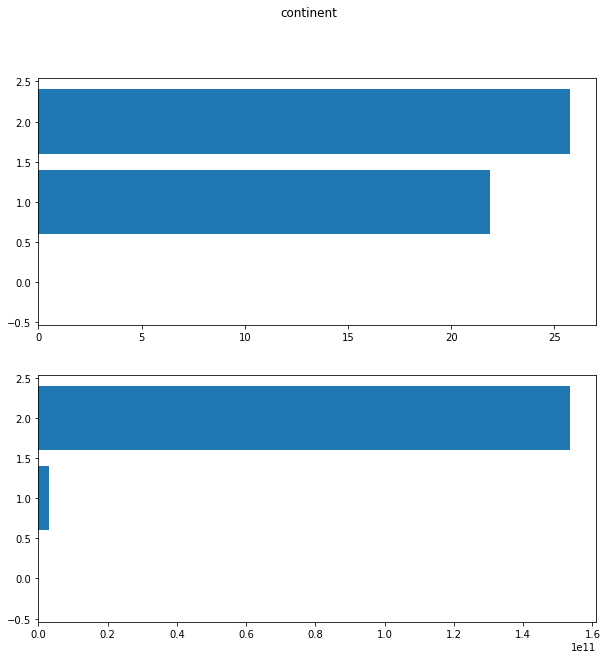

In [159]:
show_subplots('continent', train)

In [154]:
conditions = [0, 15, 25, 30]
train.continent = train.continent.map(get_codes_by_conditions('continent', train, conditions))

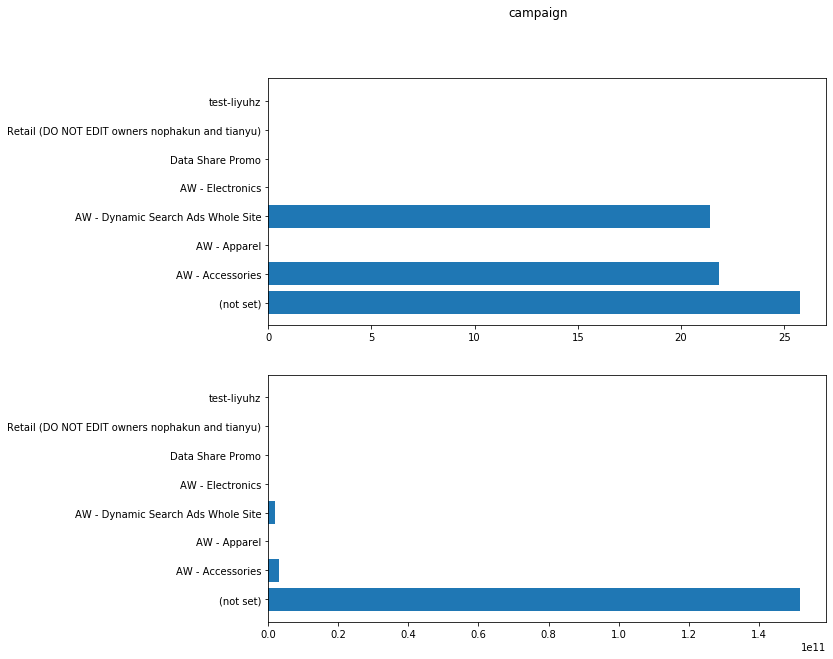

In [155]:
show_subplots('campaign', train)

In [156]:
conditions = [0, 15, 25, 30]
train.medium = train.medium.map(get_codes_by_conditions('medium', train, conditions))

In [157]:
!pip install mlxtend

In [160]:
df = pd.merge(left=train.fullVisitorId, right=train.select_dtypes(exclude=['object']), 
              left_index=True, right_index=True)
df = df.groupby('fullVisitorId').sum().reset_index()

In [161]:
X = df.drop(['fullVisitorId', 'transactionRevenue'], axis=1)
y = np.log(df.transactionRevenue + 1)

In [162]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression

selector = SequentialFeatureSelector(LinearRegression(), verbose=2, k_features=5, forward=False, n_jobs=-1)
selector.fit(X, y)
selector.subsets_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.1s remaining:    8.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    4.8s finished

[2020-05-07 18:39:17] Features: 11/5 -- score: 0.19629321414267087[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  11 | elapsed:    0.7s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   8 out of  11 | elapsed:    0.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  11 out of  11 | elapsed:    1.2s finished

[2020-05-07 18:39:19] Features: 10/5 -- score: 0.19630412731058688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.9s finished

[2020-05-07 18:39:20] Features: 9/5 -- score: 0.19629275441001193[Parallel(n_jobs=-1)]: Using backen

{12: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
  'cv_scores': array([0.20816254, 0.19829789, 0.19106005, 0.16807807, 0.21577664]),
  'avg_score': 0.196275036175349,
  'feature_names': ('channelGrouping',
   'visitNumber',
   'operatingSystem',
   'isMobile',
   'deviceCategory',
   'continent',
   'hits',
   'pageviews',
   'bounces',
   'newVisits',
   'medium',
   'isTrueDirect')},
 11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  'cv_scores': array([0.20819846, 0.19829338, 0.19108909, 0.16810932, 0.21577582]),
  'avg_score': 0.19629321414267087,
  'feature_names': ('channelGrouping',
   'visitNumber',
   'operatingSystem',
   'isMobile',
   'deviceCategory',
   'continent',
   'hits',
   'pageviews',
   'bounces',
   'newVisits',
   'medium')},
 10: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9),
  'cv_scores': array([0.20821947, 0.19829464, 0.19109213, 0.16811573, 0.21579866]),
  'avg_score': 0.19630412731058688,
  'feature_names': ('channelGrouping',
   'vis

In [163]:
df

,fullVisitorId,channelGrouping,visitNumber,operatingSystem,isMobile,deviceCategory,continent,hits,pageviews,bounces,newVisits,transactionRevenue,medium,isTrueDirect
0,0000010278554503158,2,1,3,0.0,0,1,11,8,0,1,0.0,1,0.0
1,0000040862739425590,1,1,3,0.0,0,2,2,2,0,1,0.0,1,0.0
2,0000174067426171406,2,2,2,1.0,1,2,7,5,0,0,0.0,1,1.0
3,0000786859828288100,1,1,3,0.0,0,1,1,1,1,1,0.0,1,0.0
4,0001076216361964073,2,1,3,0.0,0,2,4,4,0,1,0.0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85705,9999165400800196746,1,1,0,1.0,1,0,1,1,1,1,0.0,1,0.0
85706,9999357271435793449,1,1,3,0.0,0,2,1,1,1,1,0.0,1,0.0
85707,9999439808291150824,2,1,2,0.0,0,2,2,2,0,1,0.0,1,0.0
85708,9999470222842102470,2,1,3,0.0,0,1,8,8,0,1,0.0,1,0.0


In [164]:
X

,channelGrouping,visitNumber,operatingSystem,isMobile,deviceCategory,continent,hits,pageviews,bounces,newVisits,medium,isTrueDirect
0,2,1,3,0.0,0,1,11,8,0,1,1,0.0
1,1,1,3,0.0,0,2,2,2,0,1,1,0.0
2,2,2,2,1.0,1,2,7,5,0,0,1,1.0
3,1,1,3,0.0,0,1,1,1,1,1,1,0.0
4,2,1,3,0.0,0,2,4,4,0,1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85705,1,1,0,1.0,1,0,1,1,1,1,1,0.0
85706,1,1,3,0.0,0,2,1,1,1,1,1,0.0
85707,2,1,2,0.0,0,2,2,2,0,1,1,0.0
85708,2,1,3,0.0,0,1,8,8,0,1,1,0.0
